<a href="https://colab.research.google.com/github/kevinhhl/portfolio-management-tools/blob/main/Monte_Carlo_Simulation_Random_Walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Parameters**

(😎 User input)

In [86]:
ticker                        = "PFE"
hist_yyyy, hist_mm, hist_dd   = 2018, 1, 1            # start date, historical lookback
t0_yyyy, t0_mm, t0_dd         = 2023, 1, 1            # [t0] end date for historical lookback, and start date for simulations
tn_yyyy, tn_mm, tn_dd         = 2023, 3, 31           # [tn] end date for simulations (no. of periods to be determined based on no. of business days in between t0 and tn)
n_iters                       = 1000000               # No. of iterations for MCS


# Overview:
This script will obtain historical price data from Yahoo and then perform a Monte Carlo Simulation by doing a random walk to forecast the reasonable ranges of prices.


In [87]:
from datetime import date
import time
from pandas.tseries.offsets import BDay
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

Number of iterations should be at least 500, and 800, in order for forecasted mean and standard deviation values (respectively) to converge. [1]



In [88]:
assert n_iters > 800

# Processing source data:

In [89]:
# Alternative to importing yfinance as yf!
def get_csv_link(date_from, date_to):
  _date_from = time.mktime(date_from.timetuple())
  _date_to = time.mktime(date_to.timetuple())
  s1 = "https://query1.finance.yahoo.com/v7/finance/download/"
  _s2 = str(int(_date_from))
  _s3 = str(int(_date_to))
  s4 = "?period1="+ _s2 +"&period2="+ _s3 +"&interval=1d&events=history&includeAdjustedClose=true"
  return s1 + ticker + s4
csv = pd.read_csv(get_csv_link(date(hist_yyyy, hist_mm, hist_dd), date(t0_yyyy, t0_mm, t0_dd)))
csv

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,34.516129,34.648956,34.383301,34.573055,28.559776,17059833
1,2018-01-03,34.582542,34.886147,34.373814,34.829224,28.771389,14183151
2,2018-01-04,34.829224,35.028461,34.724857,34.905125,28.834087,13046517
3,2018-01-05,34.933586,34.990513,34.734344,34.971539,28.888950,13167517
4,2018-01-08,34.838711,34.914612,34.468693,34.582542,28.567612,19964341
...,...,...,...,...,...,...,...
1254,2022-12-23,51.560001,51.950001,51.240002,51.830002,51.358505,10666500
1255,2022-12-27,51.860001,51.930000,51.049999,51.130001,50.664871,12033800
1256,2022-12-28,51.049999,51.389999,50.750000,50.799999,50.337872,10053900
1257,2022-12-29,51.020000,51.669998,50.990002,51.330002,50.863052,8971300


**Historical Returns**

*   pc = historical log returns, based on Adjusted Close
*   drift = mean minus half-variance of historical log returns



In [90]:
import numpy as np

adj_close = csv["Adj Close"]
pc = np.log(1+adj_close.pct_change()) 

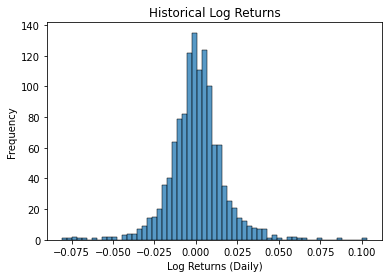

In [91]:
sb.histplot(pc.iloc[1:])
plt.title("Historical Log Returns")
plt.xlabel("Log Returns (Daily)")
plt.ylabel("Frequency");

In [92]:
mean = pc.mean()
var = pc.var()
stddev = pc.std()
drift = mean - 0.5*var
print("mean={}, var={}, drift={}".format(mean, var, drift))


mean=0.00045737885314705245, var=0.0002720509809373811, drift=0.00032135336267836187


# Performing Random Walk

In [93]:
date_t0 = date(t0_yyyy, t0_mm, t0_dd)
date_tn = date(tn_yyyy, tn_mm, tn_dd)

n_forecast = 0        # Counter++ for each business days existing in between t0 and tn
_t0 = date_t0         # tmp var.
while date(_t0.year,_t0.month,_t0.day) <= date(date_tn.year,date_tn.month,date_tn.day):
  n_forecast += 1
  _t0 += BDay(1)

In [94]:
# Init. array[n_forecast][n_iters] of zeros 
rand_returns = np.exp(drift + stddev * norm.ppf(np.random.rand(n_forecast,n_iters)))
sim_equity_curve = np.zeros_like(rand_returns)

# Assume single asset porfolio. Value of portfolio on day 1 of forecast is the Adj. Close price on that date. 
sim_equity_curve[0] = adj_close[len(adj_close)-1]

# Perform random walk and plot
for t in range(1,n_forecast):
    sim_equity_curve[t] = sim_equity_curve[t-1]*rand_returns[t]

assert(sim_equity_curve.shape==rand_returns.shape)

print("\n{}\nShape={}".format(ticker, sim_equity_curve.shape))
print("Simulation: From {} to {}; Business days={}".format(date_t0, date_tn, np.busday_count(date_t0, date_tn)))

## No longer using matplotlib to show MCS
## Plotting with matplotlib becomes too slow when n_iteration count is large
# plt.figure(figsize=(20,10))
# plt.plot(pd.DataFrame(sim_equity_curve).iloc[:,0:]);


PFE
Shape=(66, 1000000)
Simulation: From 2023-01-01 to 2023-03-31; Business days=64


In [95]:
count = 0
stdev_multi = 2

lower_bounds, center_ln, upper_bounds = [], [], []

print("{}\nt+n; \t\t\t\tstd \t\tmean \t\tmean - {}*std \t\tmean + {}*std \n"\
      .format(ticker, stdev_multi,stdev_multi))
for e in sim_equity_curve:
  std = e.std()
  mean = e.mean()
  lower_bounds.append(mean-2*std)
  center_ln.append(mean)
  upper_bounds.append(mean+2*std)
  print("t+{} \t{} \tstd = {} \tmean = {} \tlower = {} \t\tupper = {}"\
        .format(count, date_t0+BDay(count), std.round(2), mean.round(2), (mean-stdev_multi*std).round(2), (mean+stdev_multi*std).round(2)))
  count += 1


PFE
t+n; 				std 		mean 		mean - 2*std 		mean + 2*std 

t+0 	2023-01-02 00:00:00 	std = 0.0 	mean = 50.77 	lower = 50.77 		upper = 50.77
t+1 	2023-01-02 00:00:00 	std = 0.84 	mean = 50.8 	lower = 49.12 		upper = 52.47
t+2 	2023-01-03 00:00:00 	std = 1.19 	mean = 50.82 	lower = 48.45 		upper = 53.19
t+3 	2023-01-04 00:00:00 	std = 1.45 	mean = 50.84 	lower = 47.94 		upper = 53.75
t+4 	2023-01-05 00:00:00 	std = 1.68 	mean = 50.87 	lower = 47.51 		upper = 54.22
t+5 	2023-01-06 00:00:00 	std = 1.88 	mean = 50.89 	lower = 47.14 		upper = 54.65
t+6 	2023-01-09 00:00:00 	std = 2.06 	mean = 50.91 	lower = 46.8 		upper = 55.03
t+7 	2023-01-10 00:00:00 	std = 2.22 	mean = 50.94 	lower = 46.49 		upper = 55.38
t+8 	2023-01-11 00:00:00 	std = 2.38 	mean = 50.96 	lower = 46.21 		upper = 55.72
t+9 	2023-01-12 00:00:00 	std = 2.52 	mean = 50.98 	lower = 45.94 		upper = 56.03
t+10 	2023-01-13 00:00:00 	std = 2.66 	mean = 51.01 	lower = 45.69 		upper = 56.33
t+11 	2023-01-16 00:00:00 	std = 2.79 	mean 

#Output

In [96]:
print("Simulation:\tFrom {} to {}; Business days={}".format(date_t0, date_tn, np.busday_count(date_t0, date_tn)))
print("\nOn t+{}:\tExpected price interval = [{}, {}]".format(np.busday_count(date_t0, date_tn), round(lower_bounds[len(lower_bounds)-1],2),round(upper_bounds[len(upper_bounds)-1],2)))
print("\nOn t+{}:\tExpected average price = {}".format(np.busday_count(date_t0, date_tn), round(center_ln[len(center_ln)-1],2)))

Simulation:	From 2023-01-01 to 2023-03-31; Business days=64

On t+64:	Expected price interval = [38.33, 66.27]

On t+64:	Expected average price = 52.3


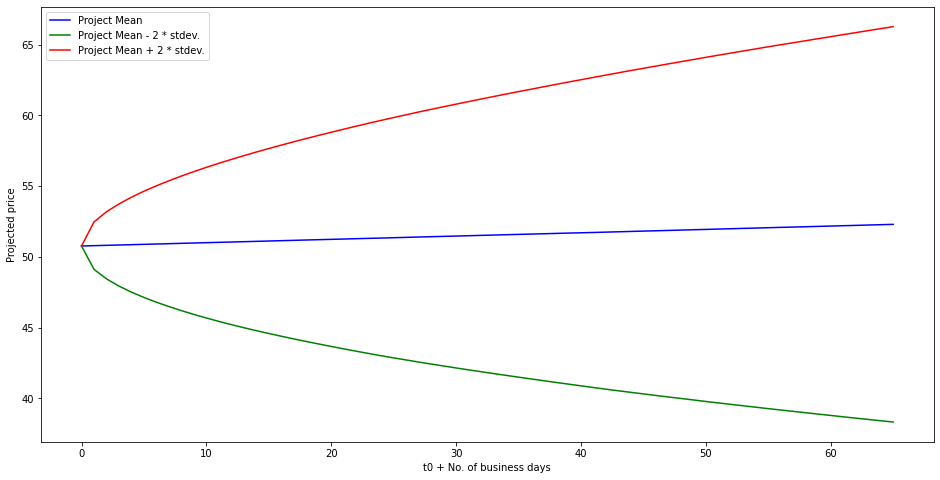

In [97]:
plt.figure(figsize=(16,8))
plt.plot(center_ln, label="Project Mean", color="blue")
plt.plot(lower_bounds, label="Project Mean - 2 * stdev.", color="green")
plt.plot(upper_bounds, label="Project Mean + 2 * stdev.", color="red")
plt.legend()
plt.ylabel("Projected price")
plt.xlabel("t0 + No. of business days")
plt.show()

<br>
<br>
<br>
<br>

---
**References:**

[1] E. Bukaçi, Th. Korini, E. Periku, S. Allkja and P. Sheperi (2016). Number of iterations needed in Monte Carlo Simulation using reliability analysis for tunnel supports. [online] https://www.ijera.com. Available at: https://www.ijera.com/papers/Vol6_issue6/Part%20-%203/J0606036064.pdf.